<a href="https://colab.research.google.com/github/sindhuja-v-jain/gesture-recognition/blob/main/Neural_Nets_Project_Starter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#import zipfile
#zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Project_data.zip', 'r')
#zip_ref.extractall('/content/drive/MyDrive/VideoData')
#zip_ref.close()

In [18]:
#data = '/content/drive/MyDrive/VideoData'

In [19]:
#print(os.listdir(data))

In [20]:
import numpy as np
import os
import imageio
from skimage.transform import resize
from PIL import Image
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [21]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [22]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/VideoData/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/VideoData/Project_data/val.csv').readlines())
batch_size = 25


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [23]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels= one_batch_of_data(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels

            remaining_sequence=len(t)%batch_size

            if (remaining_sequence != 0):
                batch_data, batch_labels= one_batch_of_data(source_path,t,num_batches,batch_size,img_idx,remaining_sequence)
                yield batch_data, batch_labels



def one_batch_of_data(source_path,t,batch,batch_size,img_idx,remaining_sequence=0):
    sequence_length = remaining_sequence if remaining_sequence else batch_size

    batch_data = np.zeros((sequence_length,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((sequence_length,5)) # batch_labels is the one hot representation of the output

    for folder in range(sequence_length): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes

            #cropping the image
            if image.shape[1] > image.shape[0]:
               diff_px = image.shape[1] - image.shape[0]
               crop_start = diff_px//2
               crop_end = crop_start + image.shape[0]
               image = image[:, crop_start:crop_end]
            elif image.shape[0] > image.shape[1]:
                 diff_px = image.shape[0] - image.shape[1]
                 crop_start = diff_px//2
                 crop_end = crop_start + image.shape[1]
                 image = image[:, crop_start:crop_end]

            #resizing the image
            image_resized=resize(image,(100,100,3))

            #normalizing the image
            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the R channel image
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the G channel image
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the B channel image

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return(batch_data, batch_labels)


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [24]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/VideoData/Project_data/train'
val_path = '/content/drive/MyDrive/VideoData/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [25]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers



In [26]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(25,100,100,3)))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [27]:
optimiser = optimizers.Adam(learning_rate=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 23, 98, 98, 32)    2624      
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 11, 49, 49, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 9, 47, 47, 64)     55360     
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 4, 23, 23, 64)     0         
 g3D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 135424)            0         
                                                                 
 dense_2 (Dense)             (None, 256)              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Source path =  /content/drive/MyDrive/VideoData/Project_data/val ; batch size = 50


<ipython-input-23-26a4f115bddb>:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


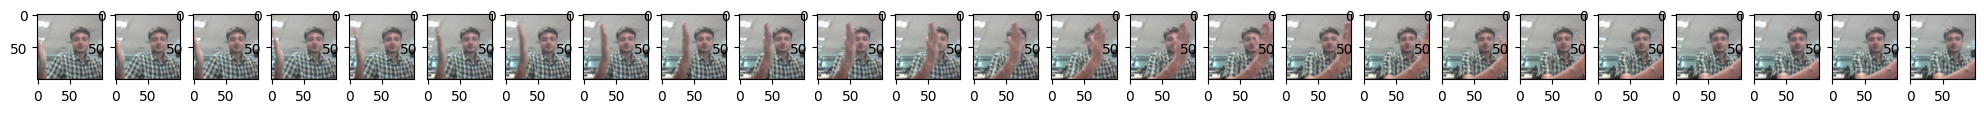

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
batch_data, batch_labels=next(val_generator)

fig, axes = plt.subplots(nrows=1, ncols=25, figsize=(25,2))
axes[0].imshow(batch_data[0,0,:,:,:])
axes[1].imshow(batch_data[0,1,:,:,:])
axes[2].imshow(batch_data[0,2,:,:,:])
axes[3].imshow(batch_data[0,3,:,:,:])
axes[4].imshow(batch_data[0,4,:,:,:])
axes[5].imshow(batch_data[0,5,:,:,:])
axes[6].imshow(batch_data[0,6,:,:,:])
axes[7].imshow(batch_data[0,7,:,:,:])
axes[8].imshow(batch_data[0,8,:,:,:])
axes[9].imshow(batch_data[0,9,:,:,:])
axes[10].imshow(batch_data[0,10,:,:,:])
axes[11].imshow(batch_data[0,11,:,:,:])
axes[12].imshow(batch_data[0,12,:,:,:])
axes[13].imshow(batch_data[0,13,:,:,:])
axes[14].imshow(batch_data[0,14,:,:,:])
axes[15].imshow(batch_data[0,15,:,:,:])
axes[16].imshow(batch_data[0,16,:,:,:])
axes[17].imshow(batch_data[0,17,:,:,:])
axes[18].imshow(batch_data[0,18,:,:,:])
axes[19].imshow(batch_data[0,19,:,:,:])
axes[20].imshow(batch_data[0,20,:,:,:])
axes[21].imshow(batch_data[0,21,:,:,:])
axes[22].imshow(batch_data[0,22,:,:,:])
axes[23].imshow(batch_data[0,23,:,:,:])
axes[24].imshow(batch_data[0,24,:,:,:])
plt.show()


In [29]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
filepath = 'models/best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [31]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /content/drive/MyDrive/VideoData/Project_data/train ; batch size = 50


<ipython-input-23-26a4f115bddb>:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


KeyboardInterrupt: 